# Long short-term memory
___

This model is based on:

```Bibtex
@inproceedings{daxenbergerWhatEssenceClaim2017,
  title = {What Is the Essence of a Claim? {{Cross-domain}} Claim Identification},
  author = {Daxenberger, Johannes and Eger, Steffen and Habernal, Ivan and Stab, Christian and Gurevych, Iryna},
  date = {2017},
  doi = {10.18653/v1/d17-1218},
}
```

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import wandb
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_score, recall_score)
from keras.layers import LSTM, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from wandb.keras import WandbCallback

from src.dataset import load_dataset
from src.evaluation import confusion_matrix_plot
from config import DATASETS, PROJECT_NAME

In [2]:
MODEL_NAME = "LSTM"
TRACKING = False
FALSE_CLASS_BALANCE = 1.0

dataset = DATASETS["dataset_2014"]

### 0. Load data

In [3]:
X_train, X_test, y_train, y_test = load_dataset(dataset_path=os.path.join(dataset["base_path"], dataset["data"]), false_class_balance=FALSE_CLASS_BALANCE)

In [4]:
y_train = y_train.apply(lambda x: 0 if x==False else 1)
y_test = y_test.apply(lambda x: 0 if x==False else 1)

### 1. Create embeddings

In [5]:
max_words = 5000  # consider the top n words in the data set only
maxlen = len(X_train["Sentence"].max())  # longest sentence to calculate max embedding len

tokenizer = Tokenizer(num_words=max_words)  # create tokanizer
tokenizer.fit_on_texts(X_train["Sentence"])  # tokenize sentences

def create_embeddings(data, labels):
  sequences = tokenizer.texts_to_sequences(data["Sentence"]) # get sequences for sentences

  data = pad_sequences(sequences, maxlen=maxlen) # padding for shorter sentences
  labels = np.asarray(labels) # return labels

  # reporting
  word_index = tokenizer.word_index
  print('Found %s unique tokens' % len(word_index))
  print('Shape of data tensor:', data.shape)
  print('Shape of label tensor:', labels.shape)

  return data, labels

### 2. Prepare dataset

In [6]:
X_train, y_train = create_embeddings(X_train, y_train)
X_test, y_test = create_embeddings(X_test, y_test)

Found 8330 unique tokens
Shape of data tensor: (1974, 197)
Shape of label tensor: (1974,)
Found 8330 unique tokens
Shape of data tensor: (494, 197)
Shape of label tensor: (494,)


### 3. Create Model

In [7]:
# Set hyperparameter
epochs = 4
batch_size = 128

In [8]:
embedding_vecor_length = 60
model = Sequential()

model.add(Embedding(max_words, embedding_vecor_length, input_length=maxlen))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

2022-01-18 21:47:33.571665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 197, 60)           300000    
                                                                 
 lstm (LSTM)                 (None, 100)               64400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 364,501
Trainable params: 364,501
Non-trainable params: 0
_________________________________________________________________
None


2022-01-18 21:47:33.576414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:47:33.576762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 21:47:33.577687: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-18 21:47:33.578067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [9]:
if TRACKING:
  report = []
  model.summary(print_fn=lambda x: report.append(x))

  wandb.init(project=PROJECT_NAME,
          config={
              "model": MODEL_NAME,
              "setup": "\n".join(report),
              "dataset": dataset["name"],
              "train_data_size": len(X_train)*0.8,
              "validation_data_size": len(X_train)*0.2,
              "test_data_size": len(X_test),
              "batch_size": batch_size,
              "learning_rate": None,
              "epochs": epochs,
              "false_class_balance": FALSE_CLASS_BALANCE
          })

### 4. Train model

In [10]:
if TRACKING:
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,  callbacks=[WandbCallback()])
else:
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/4


2022-01-18 21:47:36.299553: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13/13 [==============================] - 7s 371ms/step - loss: 0.6892 - accuracy: 0.5263 - val_loss: 0.6693 - val_accuracy: 0.6000
Epoch 2/4
13/13 [==============================] - 4s 343ms/step - loss: 0.6469 - accuracy: 0.6694 - val_loss: 0.6550 - val_accuracy: 0.6076
Epoch 3/4
13/13 [==============================] - 4s 330ms/step - loss: 0.5836 - accuracy: 0.6928 - val_loss: 0.5953 - val_accuracy: 0.6886
Epoch 4/4
13/13 [==============================] - 4s 332ms/step - loss: 0.4528 - accuracy: 0.8030 - val_loss: 0.5606 - val_accuracy: 0.7316


### 5. Predict results

In [11]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

16/16 [==============================] - 1s 40ms/step - loss: 0.5002 - accuracy: 0.7591
Accuracy: 75.91%


In [12]:
predictions = model.predict(np.array(X_test))

In [13]:
y_pred = []
for i in predictions:
  if i < 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

### 6. Evaluate results

In [14]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.71      0.74       235
           1       0.75      0.81      0.78       259

    accuracy                           0.76       494
   macro avg       0.76      0.76      0.76       494
weighted avg       0.76      0.76      0.76       494



In [15]:
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [16]:
if TRACKING:
    wandb.log({'test_f1': f1})
    wandb.log({'test_recall': recall})
    wandb.log({'test_precision': precision})
    wandb.log({'test_accuracy': accuracy})
    wandb.finish()

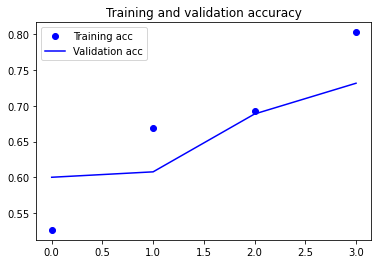

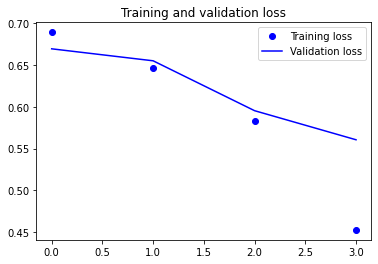

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

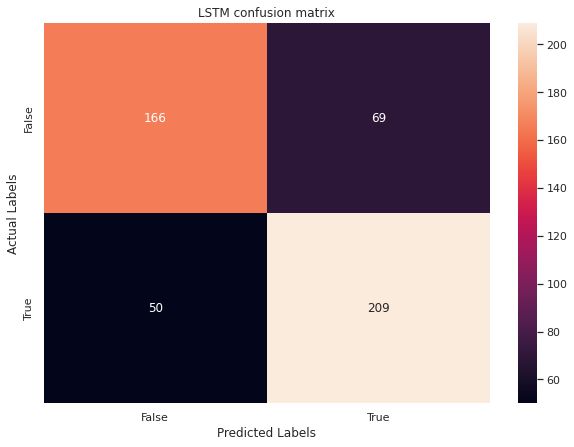

In [18]:
confusion_matrix_plot(y_test, y_pred, label=[False, True], title=MODEL_NAME+" confusion matrix")